In [1]:
import torch
import numpy as np

from datasets.dataset import transform_dataset, kfold_dataset
from R2Ntab import train as train_r2ntab, R2Ntab
from DRNet import train as train_drnet, DRNet

import sys

import matplotlib.pyplot as plt
import numpy as np

In [2]:
DRNetRules = []
DRNetAccus = []
R2NTabRules = []
R2NTabAccus = []

# Read datasets
for name in ['adult', 'heloc', 'house', 'magic']:
    X, Y, X_headers, Y_headers = transform_dataset(name, method='onehot-compare', negations=False, labels='binary')
    datasets = kfold_dataset(X, Y, shuffle=1)
    X_train, X_test, Y_train, Y_test = datasets[0]
    train_set = torch.utils.data.TensorDataset(torch.Tensor(X_train.to_numpy()), torch.Tensor(Y_train))
    test_set = torch.utils.data.TensorDataset(torch.Tensor(X_test.to_numpy()), torch.Tensor(Y_test))
    
    # Train DR-Net
    # Default learning rate (1e-2), and_lam (1e-2), and and_lam (1e-5) usually work the best. A large epochs number is necessary for a sparse rule set i.e 10000 epochs.
    net = DRNet(train_set[:][0].size(1), 50, 1)
    train_drnet(net, train_set, test_set=test_set, device='cpu', lr=1e-2, epochs=1000, batch_size=400,
                and_lam=1e-2, or_lam=1e-5, num_alter=500)
    
    # Get accuracy and the rule net
    accu = (net.predict(np.array(X_test)) == Y_test).mean()
    rules = net.get_rules(X_headers)
    DRNetRules.append(len(rules))
    DRNetAccus.append(accu)
    
    # Train R2N-tab
    # Default learning rate (1e-2), and_lam (1e-2), and and_lam (1e-5) usually work the best. A large epochs number is necessary for a sparse rule set i.e 10000 epochs.
    net = R2Ntab(train_set[:][0].size(1), 50, 1)
    train_r2ntab(net, train_set, test_set=test_set, device='cpu', lr=1e-2, epochs=1000, batch_size=400,
                 and_lam=1e-2, or_lam=1e-5, num_alter=500)
    
    # Get accuracy and the rule net
    accu = (net.predict(np.array(X_test)) == Y_test).mean()
    rules = net.get_rules(X_headers)
    R2NTabRules.append(len(rules))
    R2NTabAccus.append(accu)

Epoch: 100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s, loss=0.503, epoch accu=0.832, test accu=0.835, num rules=16, sparsity=0.96]


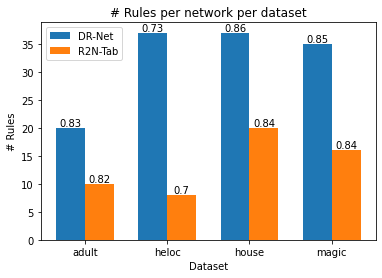

In [3]:
DRNetAccus = np.round(DRNetAccus, decimals=2)
R2NTabAccus = np.round(R2NTabAccus, decimals=2)

# Define the data for the bars
data = np.stack((DRNetRules, R2NTabRules), axis=1)

# Define the labels for the x-axis and the legend
labels = ['adult', 'heloc', 'house', 'magic']
legend_labels = ['DR-Net', 'R2N-Tab']

# Define the positions of the bars on the x-axis
x_positions = np.arange(len(labels))

# Define the width of the bars
bar_width = 0.35

# Plot the bars
fig, ax = plt.subplots()
for i in range(data.shape[1]):
    rects = ax.bar(x_positions + i * bar_width, data[:, i], bar_width, label=legend_labels[i])
    # Add text labels above the bars
    for j, rect in enumerate(rects):
        height = rect.get_height()
        if i == 0:
            label = DRNetAccus[j]
        else:
            label = R2NTabAccus[j]
        ax.text(rect.get_x() + rect.get_width() / 2, height, label, ha='center', va='bottom')

# Add labels and title to the plot
ax.set_xlabel('Dataset')
ax.set_ylabel('# Rules')
ax.set_title('# Rules / accuracy per network per dataset for 1000 epochs')

# Add x-axis ticks and labels
ax.set_xticks(x_positions + bar_width / 2)
ax.set_xticklabels(labels)

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()